In [4]:
import numpy as np
import pandas as pd

In [5]:
import tensorflow as tf

BATCH_SIZE = 40
IMG_WIDTH  = 128 
IMG_HEIGHT = 128 
DATASET_DIR = "../input/animals10/raw-img"

In [6]:
animals_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_DIR,
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = 'inferred'
)

Found 26179 files belonging to 10 classes.


2022-10-08 12:03:27.022483: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Simple Visualization

In [8]:
animals10_names = animals_dataset.class_names

2022-10-08 12:12:00.454417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


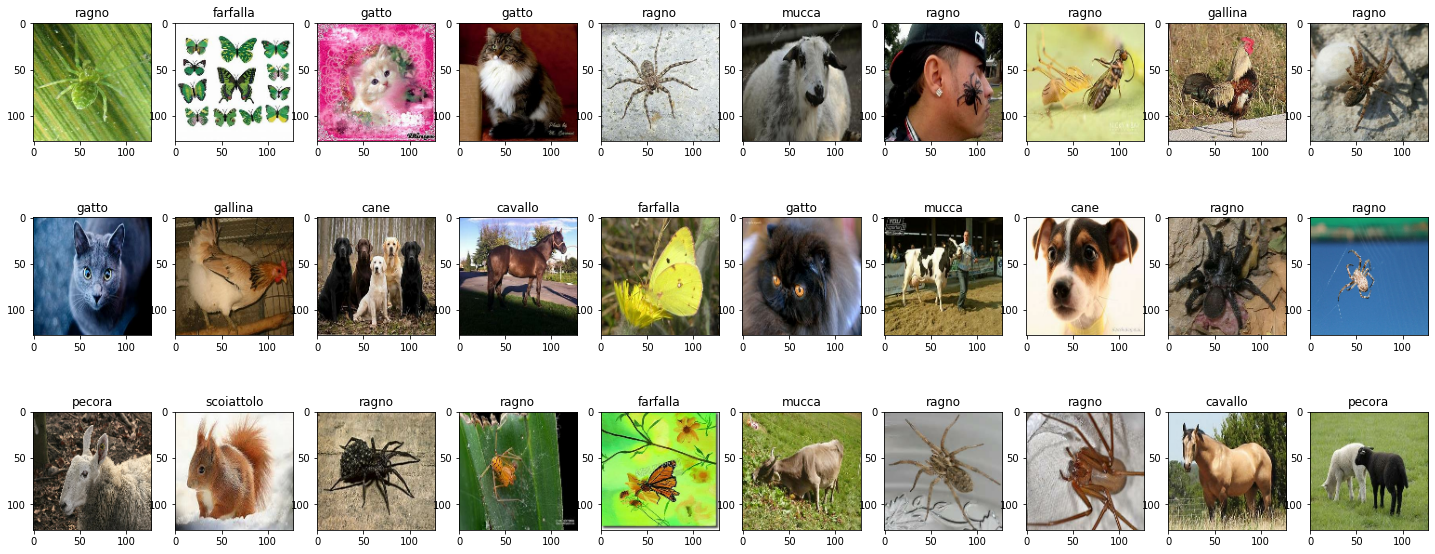

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 28))

for images, labels in animals_dataset.take(1):
    for i in range(30):
        ax = plt.subplot(8, 10, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(animals10_names[labels[i]])